# Make Figure 5A: PTEN Mutation Frequency 

This notebook creates a bar chart that shows the frequency of different PTEN mutations found across 9 cancers.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cptac
import cptac.pancan as pc
import cptac.utils as u
import plot_utils as p

In [2]:
print('cptac version:', cptac.version())

cptac version: 0.9.1


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Step 1: Create df with Mutation Types

For each cancer type, create a df that has the mutation type for each sample.

First, load in the cancer data sets from cptac.

In [4]:
en = pc.PancanUcec()
h = pc.PancanHnscc()
l = pc.PancanLuad()
ls = pc.PancanLscc()
r = pc.PancanCcrcc()
g = pc.PancanGbm()
b = pc.PancanBrca()
co = pc.PancanCoad()
#o = pc.PancanOv()

MissingFileError: Missing data file 'CRC_Prospective sample info.xlsx'. Call the download function (either 'cptac.download' or 'cptac.pancan.download', depending on which module you're using) to download it, passing 'umichcoad' to the 'dataset' parameter and '1.0' to the 'version' parameter.

Next, call get_geneotype_all_vars for each cancer type. This returns a df with columns for Mutation (type of mutation), Location (location of the mutation), and Mutation_Status (wildtype, single, or multiple mutations).  For samples with multiple mutations, a single mutation was reported based on the following priority: deletion, truncation, missense, inframe, amplification, and wildtype. 

In [7]:
gene = "PTEN"

In [9]:
endo = en.get_genotype_all_vars(gene, 'washu')
gbm = g.get_genotype_all_vars(gene, 'washu')
hnscc = h.get_genotype_all_vars(gene, 'washu')
#ovar = o.get_genotype_all_vars(gene, 'washu')
cc = r.get_genotype_all_vars(gene, 'washu')
colon = co.get_genotype_all_vars(gene, 'washu')
ld = l.get_genotype_all_vars(gene, 'washu')
lscc = ls.get_genotype_all_vars(gene, 'washu')
brca = b.get_genotype_all_vars(gene, 'washu')

In [18]:
cc

Name,Mutation,Location,Mutation_Status
Patient_ID,,,
C3L-00004,Wildtype,No_mutation,Wildtype_Tumor
C3L-00010,Wildtype,No_mutation,Wildtype_Tumor
C3L-00011,Wildtype,No_mutation,Wildtype_Tumor
C3L-00026,Wildtype,No_mutation,Wildtype_Tumor
C3L-00079,Missense,p.G132D,Single_mutation
...,...,...,...
C3N-01646,Wildtype,No_mutation,Wildtype_Tumor
C3N-01648,Wildtype,No_mutation,Wildtype_Tumor
C3N-01649,Wildtype,No_mutation,Wildtype_Tumor


In [10]:
# example
endo.head()

Name,Mutation,Location,Mutation_Status
Patient_ID,,,
C3L-00006,Nonsense_Mutation,p.R233*,Multiple_mutation
C3L-00008,Missense_Mutation,p.G127R,Single_mutation
C3L-00032,Nonsense_Mutation,p.W111*,Single_mutation
C3L-00090,Missense_Mutation,p.R130G,Multiple_mutation
C3L-00098,Amplification,Amplification,Single_mutation


# Step 2: Match Mutation Labels

Mutations in the Colon dataset were named differently. We changed these names to match the other cancers. Nonframeshift insertion was changed to match In_Frame_Ins. Frameshift deletion was changed to match Frame_Shift_Del. Nonsynonymous snv represents a missense mutation in this case. 

In [126]:
colon["Mutation"] = colon['Mutation'].replace(['nonsynonymous SNV'], 'Missense')
colon["Mutation"] = colon['Mutation'].replace(['nonframeshift insertion'], 'In_Frame_Ins')
colon["Mutation"] = colon['Mutation'].replace(['frameshift deletion'], 'Frame_Shift_Del')

colon.Mutation.value_counts()

Wildtype_Tumor     76
Deletion           25
Missense            3
Amplification       1
Frame_Shift_Del     1
Name: Mutation, dtype: int64

We simplified labels for the final figure. We grouped mutations together to create the Indel and Truncation categories. Indel includes: In_Frame_Ins and In_Frame_Del. Truncation includes: Nonsense_Mutation, Frame_Shift_Del, and Frame_Shift_Ins.

In [127]:
# Simplify mutation names, create truncation and indel groups
dfs = [endo, gbm, hnscc, cc, ld, brca, lscc, colon]
for df in dfs:
    df['Mutation'].where(df['Mutation'] != 'Missense_Mutation', 'Missense', inplace = True) # replace when false
    df['Mutation'].where(df['Mutation'] != 'Wildtype_Tumor', 'Wildtype', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'In_Frame_Del', 'Indel', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'In_Frame_Ins', 'Indel', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'Nonsense_Mutation', 'Truncation', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'Frame_Shift_Del', 'Truncation', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'Frame_Shift_Ins', 'Truncation', inplace = True)

The get_genotype_all_var function created the No_Mutation label when no somatic mutations were found for PTEN in the Luad dataset. This is the same as Wildtype_Tumor. 

In [128]:
ld["Mutation"] = ld['Mutation'].replace(['No_Mutation'], 'Wildtype')
colon["Mutation"] = colon['Mutation'].replace(['No_Mutation'], 'Wildtype')

# Step 3: Create Figure

Create a list of the mutation dataframes. Create a list of cancer names for the figure legend. Call the plot_mutations function.

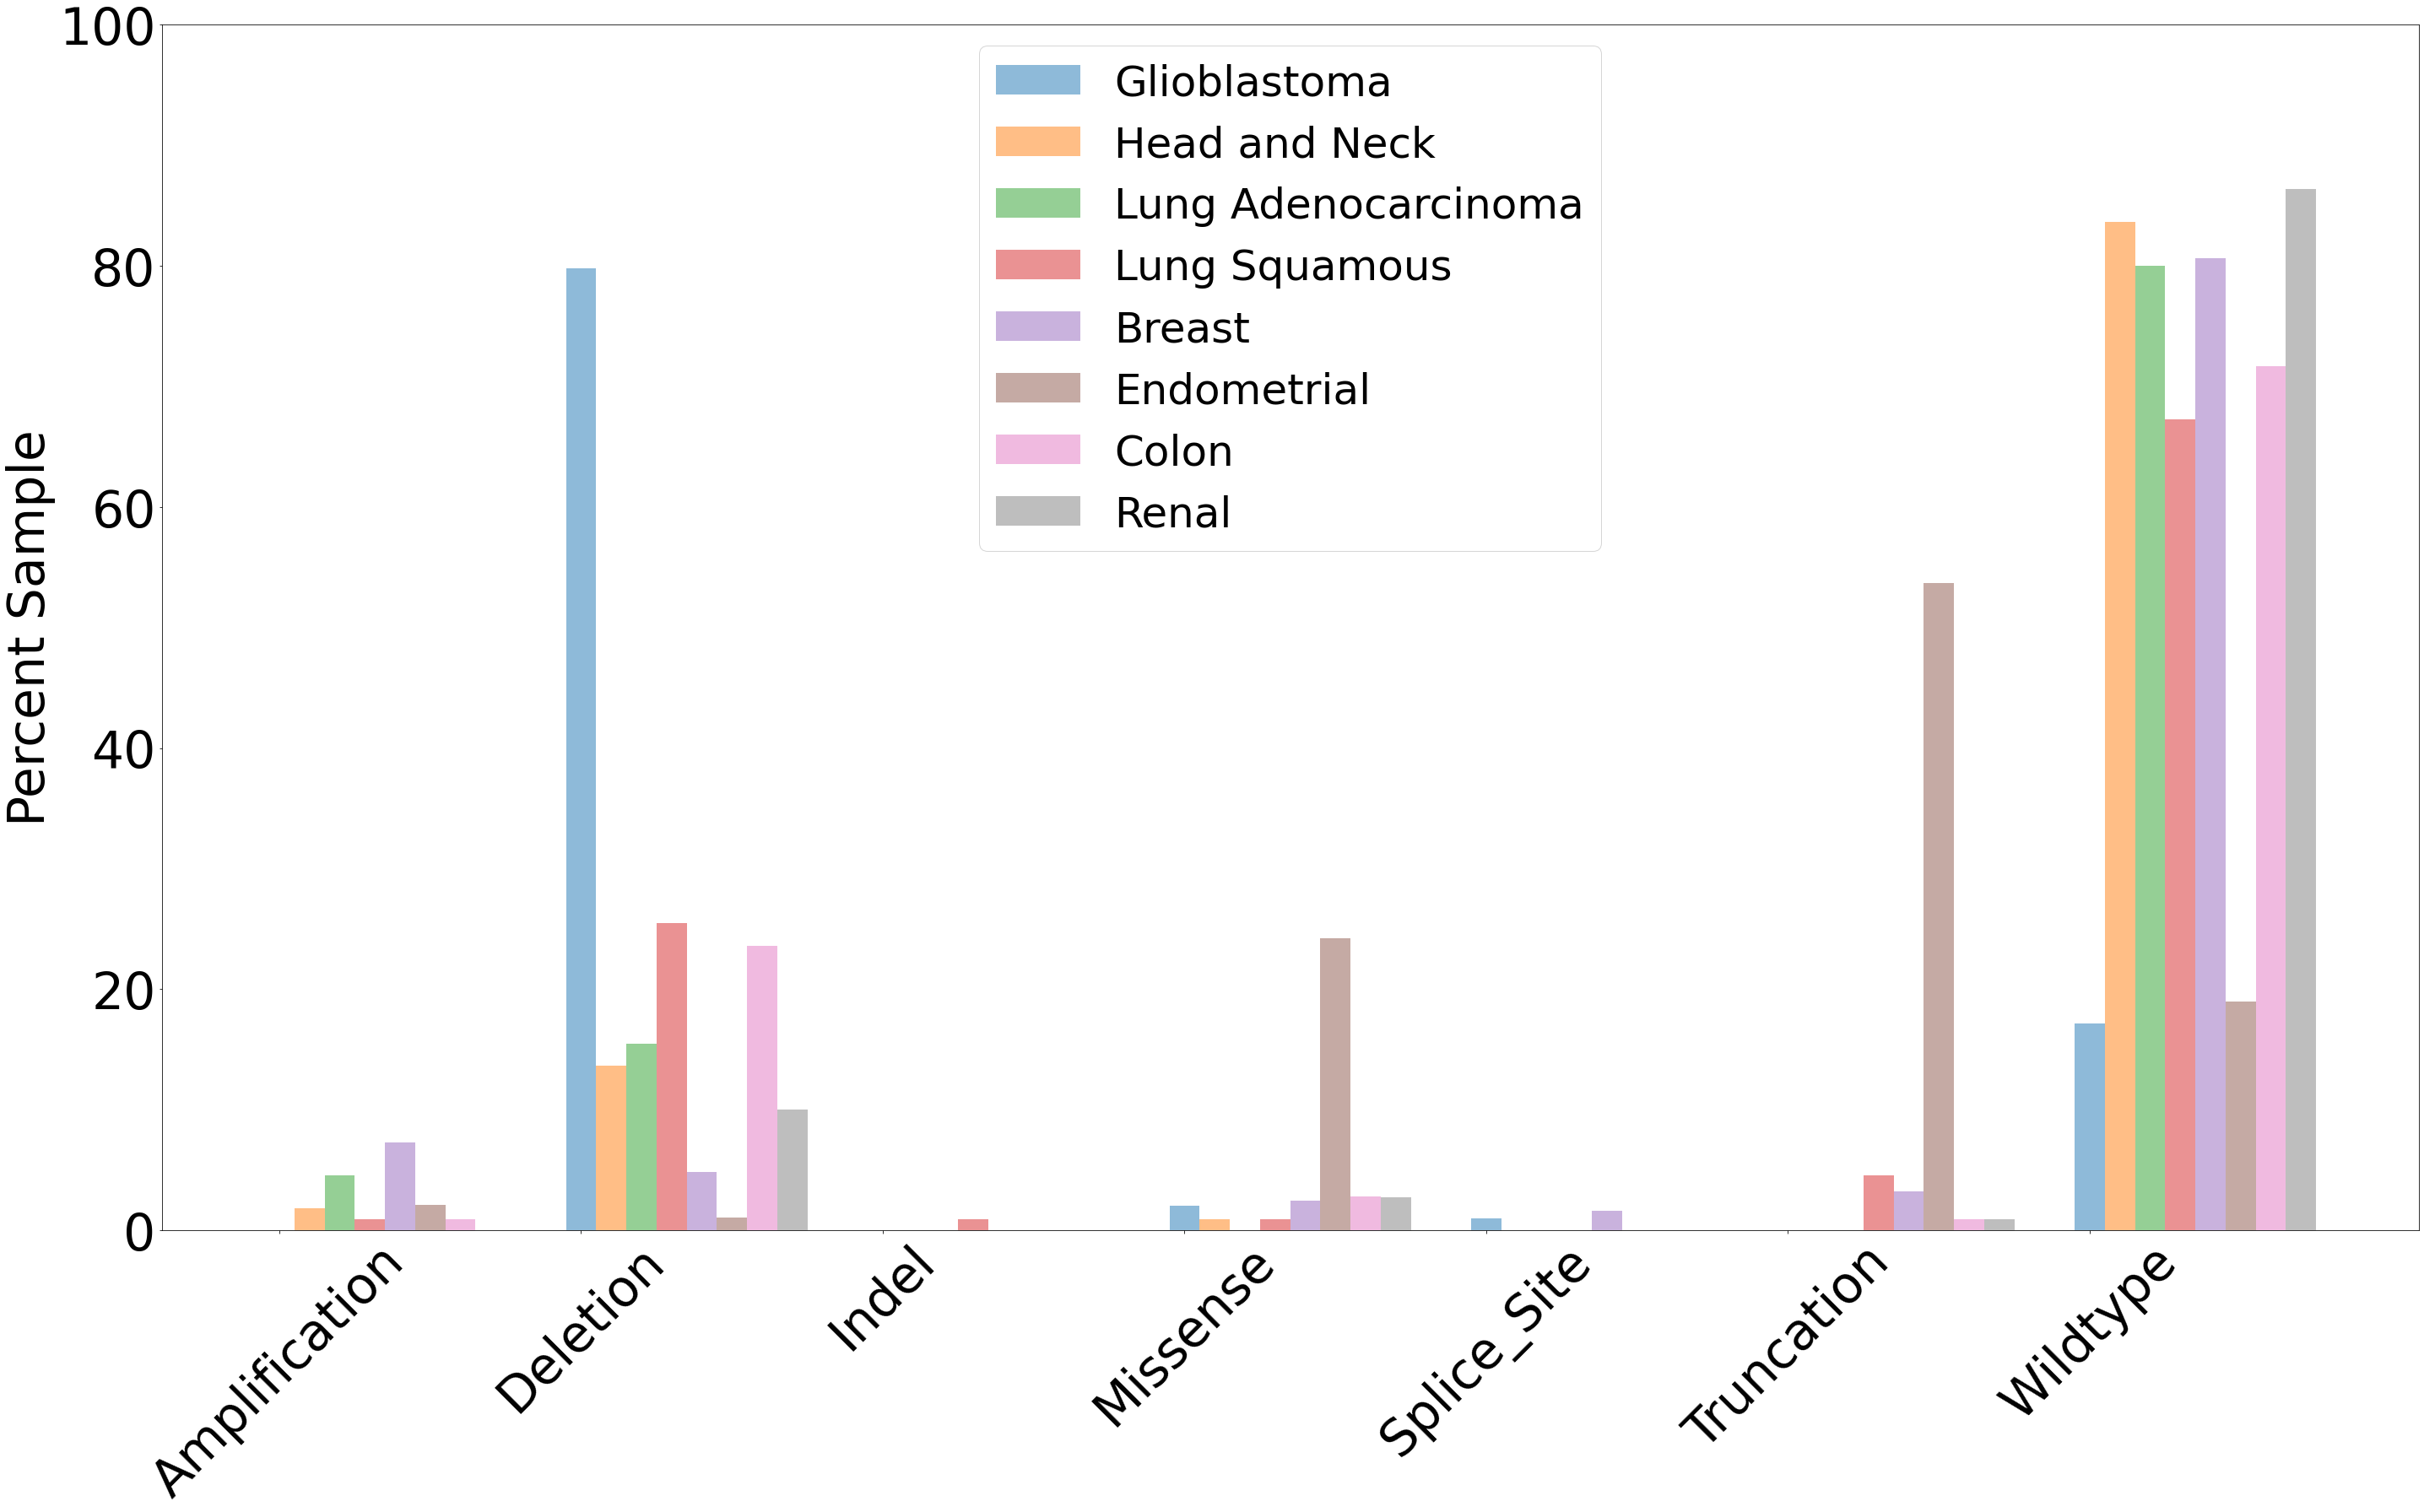

In [129]:
dfs = [gbm, hnscc, ld, lscc, brca, endo, colon, cc]
names = ['Glioblastoma', 'Head and Neck', 'Lung Adenocarcinoma', 'Lung Squamous', 'Breast', 
         'Endometrial', 'Colon', 'Renal']
p.figure1_plot_mutations(dfs, names, save_to_path = "Fig_5A_pancan.png")

# Calculate percentage of PTEN deletion in cancers

The manuscript mentions the rounded percentages of PTEN deletions for the 7 cancers with frequent deletions.

In [15]:
cancer_dfs = {'GBM':gbm, 'LSCC':lscc, 'BR':brca, 
              'HNSCC':hnscc, 'LUAD':ld, 'ccRCC':cc, 'EC':endo, 'CO':colon} # 'OV':ovar

for cancer in cancer_dfs:
    df = cancer_dfs[cancer]
    vc = df.Mutation.value_counts()
    total = len(df)
    cnv_del = vc.Deletion
    print(cancer)
    print('total_tumor_samples:',total)
    print(cnv_del,'/',total,'* 100 =', round(cnv_del/total * 100),'\n')

GBM
total_tumor_samples: 99
79 / 99 * 100 = 80 

LSCC
total_tumor_samples: 110
28 / 110 * 100 = 25 

BR
total_tumor_samples: 124
6 / 124 * 100 = 5 

HNSCC
total_tumor_samples: 110
15 / 110 * 100 = 14 

LUAD
total_tumor_samples: 110
17 / 110 * 100 = 15 

ccRCC
total_tumor_samples: 110
11 / 110 * 100 = 10 

EC
total_tumor_samples: 95
1 / 95 * 100 = 1 

CO
total_tumor_samples: 106
12 / 106 * 100 = 11 



# Calculate percentage of PTEN truncation in tumors

The manuscript mentions the rounded percentage of PTEN truncation mutations for Endometrial. 

In [14]:
cancer_dfs = {'EC':endo}
for cancer in cancer_dfs:
    df = cancer_dfs[cancer]
    vc = df.Mutation.value_counts()
    total = len(df)
    trunc = vc.Truncation
    print(cancer)
    print('total_tumor_samples:',total)
    print(trunc,'/',total,'=', round(trunc/total * 100),'\n')

EC
total_tumor_samples: 95
51 / 95 = 54 

